In [1]:
import os
import scanpy as sc
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import spatial
import scipy.stats as stats
import squidpy as sq
import statsmodels.stats as sm_stats
import matplotlib
from itertools import compress
import networkx as nx
from tqdm import tqdm
import scipy as sp
from operator import itemgetter
from scipy.cluster.hierarchy import linkage, leaves_list
import anndata

from pyvis.network import Network

In [2]:
adata_dir = 'adata_env'

adata = sc.read('adata_integrated.h5ad')
patients = adata.obs['patient'].cat.categories

env_names = adata.obs.columns[['env_' in el for el in adata.obs.columns]]
env_names = [e for e in env_names if 'MT' not in e]

rctd_names = adata.obs.columns[['rctd_' in el for el in adata.obs.columns]]
rctd_names = [r for r in rctd_names if 'Mast' not in r]

sigs = env_names + rctd_names

In [3]:
# remove outlier sample
keep = [all([s not in patient for s in ['313']]) for patient in patients]
patients = list(compress(patients, keep))
adata = adata[adata.obs['patient'].isin(patients)]

In [4]:
def pearsonr_df(df):
    columns = df.columns
    l = len(columns)
    output = pd.DataFrame(0, index=columns, columns=columns)
    pvalues = pd.DataFrame(1, index=columns, columns=columns)
    for i in range(l):
        for j in range(i+1):
            (output.iloc[i,j], pvalues.iloc[i,j]) = stats.pearsonr(df[columns[i]],df[columns[j]])
            (output.iloc[j,i],pvalues.iloc[j,i]) = (output.iloc[i,j],pvalues.iloc[i,j])
            
    return output, pvalues

In [5]:
index = pd.MultiIndex.from_product([sigs,sigs])
X = pd.DataFrame(0, index= index, columns=patients)
P = pd.DataFrame(1, index= index, columns=patients)
Padj = P.copy()
obs = adata.obs

l = len(sigs)
for p in patients:
    _obs = obs.loc[obs['patient']==p,:]
    
    # correlation
    mcorr,pvalues = pearsonr_df(_obs.loc[:,sigs])
    
    # populate matrix
    for i in range(l):
        for j in range(i+1):
            s1 = sigs[i]
            s2 = sigs[j]
            X.loc[(s1,s2),p] = mcorr.loc[s1,s2]
            P.loc[(s1,s2),p] = pvalues.loc[s1,s2]
            
# remove empty rows (empty triangle in the matrix)
keep = ~(X==0).all(axis=1)

# calculate Padj
for p in P.columns:
    Padj.loc[keep,p] = sm_stats.multitest.multipletests(pvals = P.loc[keep,p], method='fdr_bh')[1]
    
    for i in range(l):
        for j in range(i+1):
            s1 = sigs[i]
            s2 = sigs[j]
            X.loc[(s2,s1),p] = X.loc[(s1,s2),p]
            P.loc[(s2,s1),p] = P.loc[(s1,s2),p]
            Padj.loc[(s2,s1),p] = Padj.loc[(s1,s2),p]

/Users/cpc45/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/cpc45/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


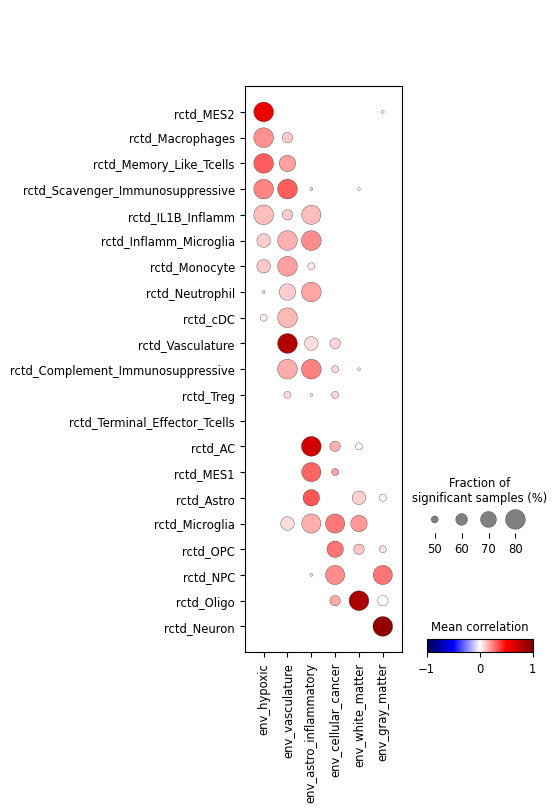

In [7]:
# dot plot
pthr = 0.01
X[Padj>pthr] = 0
Xadata_df = pd.DataFrame(np.nan, index=list(patients)*len(rctd_names), columns=env_names+['target'])
for s in env_names:
    smatrix = X.loc[pd.IndexSlice[:, rctd_names], :].xs(s, level=0).T.melt()
    smatrix.index = list(patients)*len(rctd_names)
    Xadata_df[s] = smatrix['value']
    Xadata_df['target'] = smatrix['variable']

sigs_sorted1 = np.array(['rctd_MES2','rctd_Macrophages','rctd_Memory_Like_Tcells','rctd_Scavenger_Immunosuppressive','rctd_IL1B_Inflamm',\
                         'rctd_Inflamm_Microglia','rctd_Monocyte','rctd_Neutrophil','rctd_cDC','rctd_Vasculature',\
                            'rctd_Complement_Immunosuppressive','rctd_Treg','rctd_Terminal_Effector_Tcells','rctd_AC','rctd_MES1',\
                                'rctd_Astro','rctd_Microglia','rctd_OPC','rctd_NPC','rctd_Oligo','rctd_Neuron'])
sigs_sorted2 = np.array(['env_hypoxic','env_vasculature','env_astro_inflammatory','env_cellular_cancer','env_white_matter',\
              'env_gray_matter'])

Xadata = anndata.AnnData(X=Xadata_df.iloc[:,:-1],\
                         obs=Xadata_df['target'].to_frame(),\
                         var=Xadata_df.columns[:-1].to_frame())
Xadata.obs['target'] = Xadata.obs['target'].astype('category')
Xadata.obs['target'] = Xadata.obs['target'].cat.reorder_categories(sigs_sorted1)

sc.pl.dotplot(Xadata, sigs_sorted2, groupby='target', vmin=-1, vmax=1, cmap='seismic',
              dot_max=0.8, dot_min=0.4, \
              colorbar_title='Mean correlation', size_title='Fraction of\nsignificant samples (%)', save='_corr_env_rctd.pdf')

In [8]:
Xagg = pd.DataFrame(0, index= X.index, columns=['mean_correlation','n_samples_significant'])
Xagg.loc[:,'mean_correlation'] = X[X!=0].median(axis=1)
Xagg.loc[:,'n_samples_significant'] = (Padj[X>0]<pthr).sum(axis=1)/(Padj!=np.nan).sum(axis=1)

In [9]:
Xagg.loc[pd.IndexSlice[rctd_names, env_names],:].to_csv('corr_rctd2env.csv')